In [2]:
import os
import random
import smtplib
from email.mime.text import MIMEText
from dotenv import load_dotenv
from langchain_groq import ChatGroq
# from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Dict, List
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage

In [3]:
# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")
email_password=os.getenv("SMTP_PASSWORD")
email_address=os.getenv("EMAIL_ADDRESS")

In [4]:
# Define State
class State(TypedDict):
    messages: Annotated[List[Dict], add_messages]

In [5]:
# OTP Storage
otp_store: Dict[str, str] = {}

In [6]:
# Define Chat Model
llm = ChatGroq(model_name="Llama3-8b-8192", temperature=0)
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [7]:
# Web search
def search_duckduckgo(query: str):
    """Searches DuckDuckGo using LangChain's DuckDuckGoSearchRun tool."""
    search = DuckDuckGoSearchRun()
    return search.invoke(query)

In [8]:
# Send OTP
def send_otp(to_email):
    """Sends a one-time password (OTP) to the specified email address."""
    otp = str(random.randint(100000, 999999))
    otp_store[to_email] = otp
    msg = MIMEText(f"Your OTP is: {otp}")
    msg["Subject"] = "Your OTP for Historical Agent AI"
    msg["From"] = email_address
    msg["To"] = to_email

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(email_address, email_password)
        server.send_message(msg)
    return f"I have sent a 6-digit OTP to {to_email}. Please verify."

In [9]:
send_otp("meinvikashoon@gmail.com")

'I have sent a 6-digit OTP to meinvikashoon@gmail.com. Please verify.'

In [10]:
# Verify OTP
def verify_otp(user_email, user_otp):
    """Verifies the OTP with our given otp store dictionary"""
    user_otp = str(user_otp)
    if otp_store[user_email] == user_otp:
        return "OTP verified! I'll send more details to your email."
    return "Incorrect OTP. Please try again."

In [11]:
otp_store

{'meinvikashoon@gmail.com': '588783'}

In [12]:
verify_otp("meinvikashoon@gmail.com",588783)

"OTP verified! I'll send more details to your email."

In [13]:
verify_otp("meinvikashoon@gmail.com",5887831)

'Incorrect OTP. Please try again.'

In [14]:
# Send email
def send_email(to_email, content):
    """Send an email to the specified email address with the provided content."""
    msg = MIMEText(content)
    msg["Subject"] = "Places suggested by Historical Agent AI"
    msg["From"] = email_address
    msg["To"] = to_email

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(email_address, email_password)
        server.send_message(msg)
    return "I have shared you the lot of places to visit around to your email."

In [15]:
# Creating agents
historical_agent = create_react_agent(
    model = llm,
    tools = [search_duckduckgo],
    name = "historical_places_expert",
    prompt = "You are a historical agent. You has the knowledge of historical monuments across the world with access to web search."
)

otp_sender_agent = create_react_agent(
    model = llm,
    tools = [send_otp],
    name = "otp_sender",
    prompt = "You are an otp sender agent. Your task is to send the OTP with the send_otp function."
)

otp_verify_agent = create_react_agent(
    model = llm,
    tools = [verify_otp],
    name = "otp_verifier",
    prompt = "You are an otp verifier agent. Your task is to verify the OTP of the email address by using verify_otp function."
)

content_sender_agent = create_react_agent(
    model = llm,
    tools = [send_email],
    name = "content_sender",
    prompt = "You are an email sender agent. Your task is to send the email with provided content by using send_email function."
)

In [16]:
# Create supervisor workflow
workflow = create_supervisor(
    [historical_agent, otp_sender_agent, otp_verify_agent, content_sender_agent],
    model = llm,
    prompt = (
        "You are a team supervisor managing a historical_places_expert, otp_sender, otp_verifier and content_sender."
        "User will ask for Historical places for this, use historical_agent"
        "Suggest user to provide email address so that you can send the suggested Historical places to email"
        "If user provide the email address, send OTP by using otp_sender_agent"
        "Verify the OTP, use otp_verify_agent"
        "Send the suggested Historical places to email address, use content_sender_agent"
    )
)

In [17]:
# Compile and run
app = workflow.compile()

In [18]:
# Initialize State
state = State(messages=[])

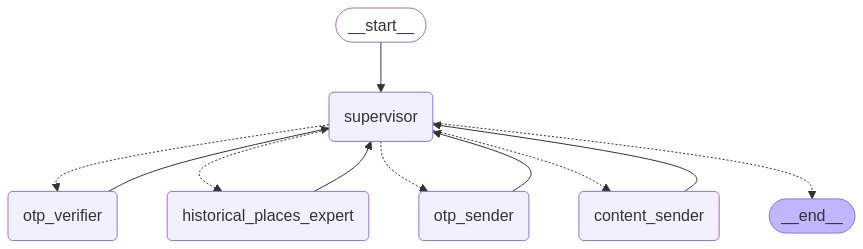

In [19]:
from IPython.display import Image,display

# To see the graph’s connection visually
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
state

{'messages': []}

In [ ]:
state = {"messages": state['messages'] + [HumanMessage(content="My email address is meinvikashoon@gmail.com")]}
state = app.invoke(state)

In [ ]:
state

In [ ]:
for m in state["messages"]:
    m.pretty_print()